# Online Convex Optimization : Project
(by Laure FERRARIS, Éloïse MILIN and Grégoire SALHA)

In [5]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

## 1 - Peliminary

**1.** Download MNIST dataset in csv at `https://pjreddie.com/projects/mnist-in-csv/`.

In [6]:
# Import data
folder_path = 'mnist_data'
mnist_train = pd.read_csv(os.path.join(folder_path,'mnist_train.csv'), header=None)
mnist_test = pd.read_csv(os.path.join(folder_path,'mnist_test.csv'), header=None)

mnist_train = mnist_train.to_numpy()
mnist_test = mnist_test.to_numpy()

We display a random digit.

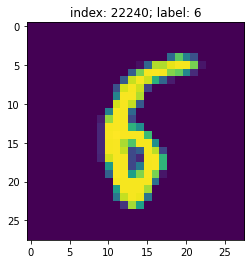

In [3]:
idx_rdm = random.randint(0, mnist_train.shape[0]-1)
label = mnist_train[idx_rdm, 0]
img = mnist_train[idx_rdm, 1:]

plt.imshow(img.reshape(28,28))
plt.title(f"index: {idx_rdm}; label: {label}")
plt.show()

**2.** Consider the binary classifictaion 0 vs other digits. Create labels $b_i$ and normalize variable $a_i$ so that the grey scale takes value in [0,1]. add an intercept.

In [4]:
b_train = 2*(mnist_train[:,0]==0)-1
b_test = 2*(mnist_test[:,0]==0)-1

a_train = mnist_train[:,1:] / 255
a_test = mnist_test[:,1:] / 255

## 2 - Gradient Descent

**1.** Implement the unconstrained GD as seen during OCO lectures.

First of all, lets define some auxiliary functions.  
  
**regularized hinge**:
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - b_i x^T a_i) + \frac{\lambda}{2} ||x||^2
$$  
  
**gradient of regularized hinge**:

$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (-b_i*a_i) \mathbb{1}_{(b_i x^T a_i)<1}   + \lambda x
$$

In [462]:
# Cost function : regularized hinge loss
def hingereg(x, a, b, llambda) :
    threshold = a.dot(x) * b
    cost      = 1 - a.dot(x) * b
    cost[threshold>=1] = 0
    return cost.reshape(-1,a.shape[1]).mean() + (llambda/2)*(x**2).sum()

# The corresponding gradient
def gradreg(x, a, b, llambda) :
    threshold = a.dot(x) * b
    gradient  = -(b*a.T).T
    gradient[threshold>=1] = 0
    return gradient.reshape(-1,a.shape[1]).mean(axis=0) + llambda*x

# The instatenuous gradient
def instgradreg(x, a, b, llambda) :
    threshold = (a * x * b)<1
    gradient  = -(b*a.T).T
    grad = gradient * threshold
    return grad + llambda*x

def rate(x, a, b) :
    return ((b * np.dot(a,x.transpose()).T).T > 0).mean(axis=0)

<hr>

**Algorithm 1 :** Gradient Descent.

<hr>

> **Parameters :** Epoch $T$, step-size ($\eta_t$).<br/>
  **Initialization :** Initial point $x_1 \in \mathcal{K}$.<br/>
  For each iteration $t = 1,\dots,T$ :

> $$\begin{align}
  y_{t+1} &= x_t - \eta_t \nabla f(x_t) \\
  x_{t+1} &= \Pi_{\mathcal{K}}(y_{t+1})
  \end{align}$$

> **Return :** $x_{T+1}$

<hr>  

In [6]:
def GD(a, b, init, grad, llambda=1, iters=100) :
    x    = np.zeros((iters+1, init.size))
    x[0] = init
    
    for t in range(iters) :
        eta    = 1/(llambda*(t+1))
        x[t+1] = x[t] - eta*grad(x[t], a, b, llambda)
    
    return x

In [7]:
%%time
xGD    = GD(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/3, iters=100)
rateGD = rate(xGD, a_test, b_test)

CPU times: user 1min 32s, sys: 18 s, total: 1min 50s
Wall time: 49.5 s


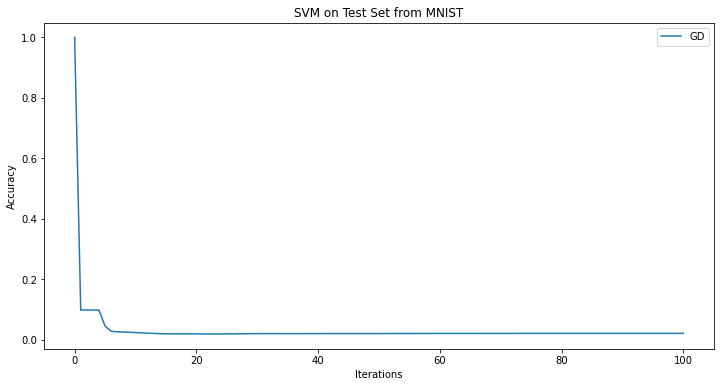

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(101), 1-rateGD, label="GD")
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig('GD.jpg');

**2.** Implement also the $\ell^1$-bal projection and implement the projected GD.

In [9]:
def proj_simplex(x):
    assert (x >= 0).all() # In this implementation x has to be positive
    assert (x.sum() > 1)  # In this implementation x is out of l1 ball
    n  = x.size                
    u  = -np.sort(-x)
    su = np.cumsum(u)
    d0 = np.max(np.where(u > (su-1)/np.arange(1,n+1)))
    theta = (su[d0]-1)/(d0+1)
    w = np.maximum(x - theta, 0)
    return w

def proj_l1(x, z=1.):
    v = np.abs(x)
    if sum(v) > z:
        u = proj_simplex(v/z)  
        x = np.sign(x)*u
    return x

def GDproj(a, b, init, grad, llambda=1, z=1., iters=100) :
    x = np.zeros((iters+1, init.size))
    x[0] = init
    
    for t in range(iters) :
        eta = 1/(llambda*(t+1))
        x[t+1] = proj_l1(x[t] - eta*grad(x[t], a, b, llambda), z)
    
    return x

In [10]:
%%time
xGDproj    = GDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/3, z=100.)
rateGDproj = rate(xGDproj, a_test, b_test)

CPU times: user 1min 30s, sys: 16.6 s, total: 1min 47s
Wall time: 45.8 s


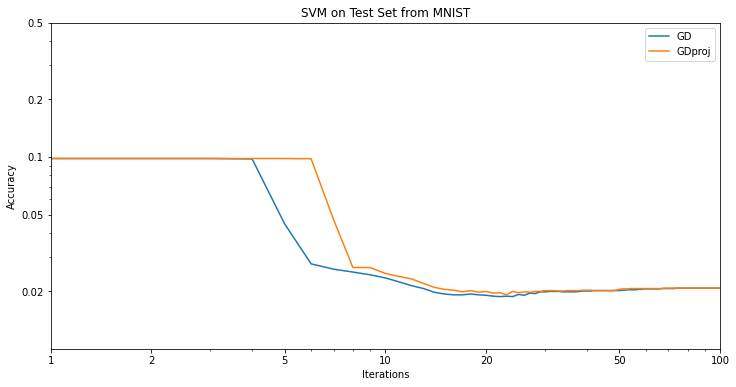

In [446]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(101), 1-rateGD, label="GD")
ax.plot(np.arange(101), 1-rateGDproj, label="GDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 100)  
ax.set_xticks([1,2,5,10,20,50,100])
ax.set_xticklabels(['1','2','5','10','20','50','100']) 
ax.set_ylim(0.01, 0.5)  
ax.set_yticks([0.02,0.05,0.1,0.2,0.5])
ax.set_yticklabels(['0.02','0.05','0.1','0.2','0.5']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("GD_GDproj.jpg");

**3.** Discuss the choice of the hyperparameters $\lambda$ and $z$, the parameters of the $\ell^2$-regularization and the radius of the $\ell^1$-ball, respectively.

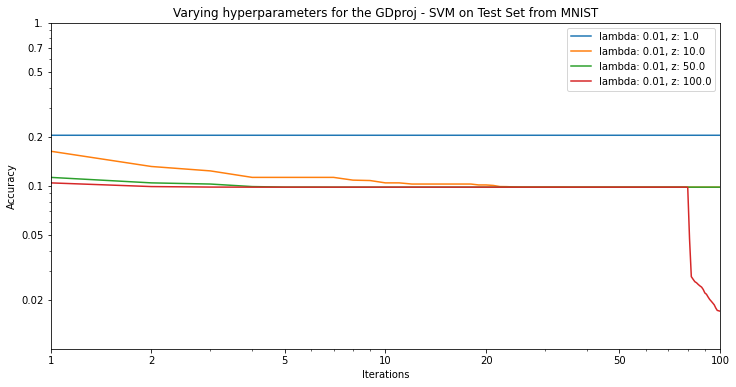

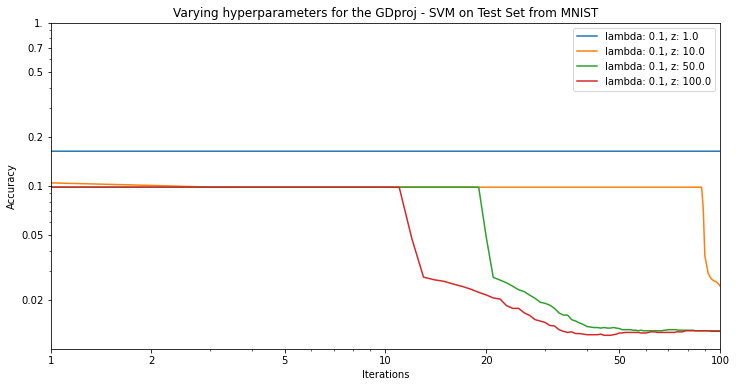

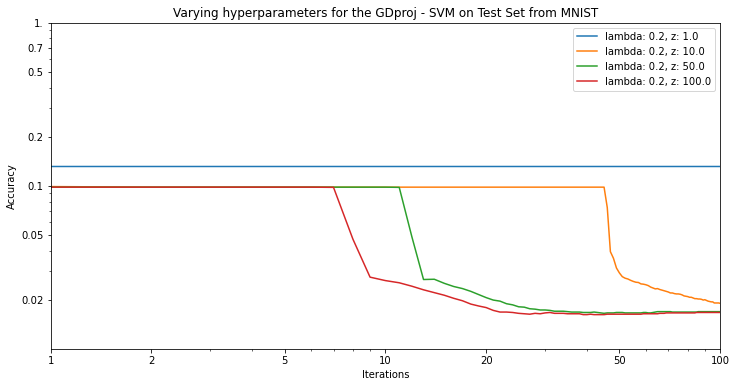

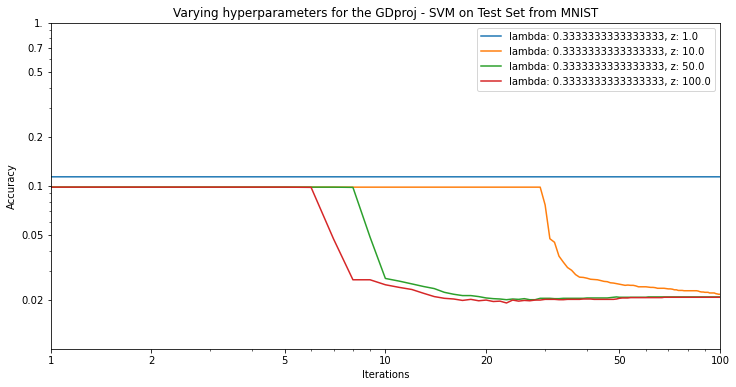

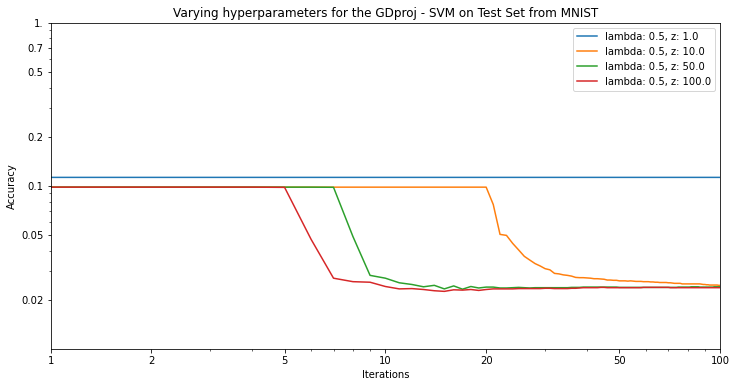

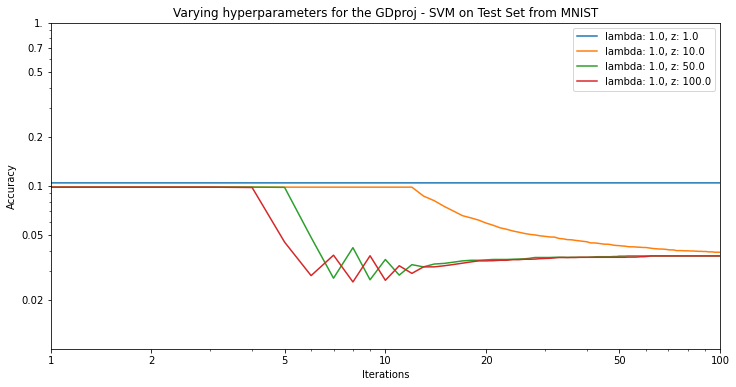

In [12]:
Llambda = [1/100, 1/10, 1/5, 1/3, 1/2, 1.]
#Llambda = [1/5, 1.]
Z = [1., 10., 50., 100.]
#Z = [10, 50]

for llambda in Llambda:
    fig, ax = plt.subplots(figsize=(12,6))
    for z in Z:
        x_star = GDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=llambda, z=z)
        ratex_star = rate(x_star, a_test, b_test)       
        ax.plot(np.arange(101), 1-ratex_star, label=f"lambda: {llambda}, z: {z}")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 100)  
    ax.set_xticks([1,2,5,10,20,50,100])
    ax.set_xticklabels(['1','2','5','10','20','50','100']) 
    ax.set_ylim(0.01, 1.)  
    ax.set_yticks([0.02,0.05,0.1,0.2,0.5,0.7,1.])
    ax.set_yticklabels(['0.02','0.05','0.1','0.2','0.5','0.7','1.']) 
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Accuracy")
    ax.set_title("Varying hyperparameters for the GDproj - SVM on Test Set from MNIST")
    ax.legend(loc="best")
    plt.savefig(f"GDproj_Param_lamb:{llambda}.jpg");

We observe that the setting of the parameters is critical for a good classification as for an efficient speed of convergence.  
  
It seems that the **radius z** shouldn't be too small. Increasing **z** from 1 to 100 improves performances of the $\textbf{GDproj}$ algorithm in terms of speed of convergence. This makes us want to observe what happens when **z** $> 100$.  

**Lambda** set to 0.1 gives the best accuracy for 100 iterations.  

We now explore the algorithm with $z \geq 100$ and $\lambda \leq 0.1$ :  
  

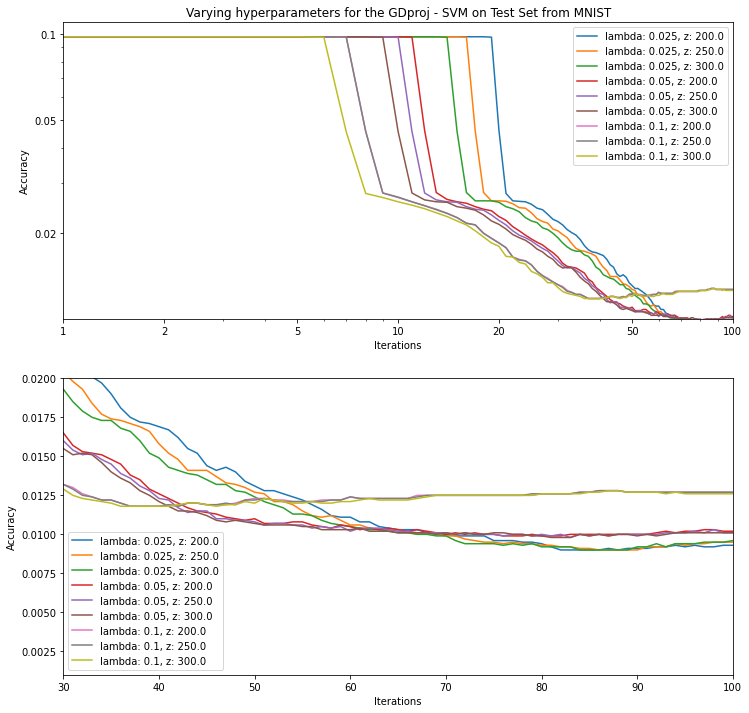

In [56]:
Llambda = [1/40, 1/20, 1/10]
#Llambda = [1/5, 1.]
Z = [200., 250., 300.]
#Z = [10, 50]

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))


for llambda in Llambda:
    for z in Z:
        x_star = GDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=llambda, z=z)
        ratex_star = rate(x_star, a_test, b_test)       
        ax1.plot(np.arange(101), 1-ratex_star, label=f"lambda: {llambda}, z: {z}")
        ax2.plot(np.arange(101), 1-ratex_star, label=f"lambda: {llambda}, z: {z}")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1, 100)  
    ax1.set_xticks([1,2,5,10,20,50,100])
    ax1.set_xticklabels(['1','2','5','10','20','50','100']) 
    ax1.set_ylim(0.01, 0.11)  
    ax1.set_yticks([0.02,0.05,0.1])
    ax1.set_yticklabels(['0.02','0.05','0.1']) 
    ax2.set_xlim(30, 100)  
    ax2.set_ylim(0.001, 0.02)  
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Accuracy")
    ax1.set_title("Varying hyperparameters for the GDproj - SVM on Test Set from MNIST")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    plt.savefig(f"Opt_Param_GDproj.jpg");

Performances are quite similar. We set $\lambda$ to $1/40$. It seems that we could try $z \geq 300$.

## 3 - Stochastic Gradient Descent

**1.** Implement the unconstrained and the projected SGD as seen during OCO lectures.

We recall the soft margin problem which is a strongly convex CO problem with :  
  
  $$f(x) = \frac{1}{n} \sum_{i=1}^n \ell_{a_i, b_i}(x) + \frac{\lambda}{2} \| x\|^2.$$  
  where $\ell_{a,b}(x) = \max(0, 1 - bx^ta).$  

Sampling $I$ uniformly over ${\left\{1, ..., n\right\}}$ one gets the approximation :    
    
  $$\widehat{\nabla f_{I}}(x) = \nabla \ell_{a_I, b_I}(x) + \lambda x.$$    
  where $\nabla \ell_{a,b}(x) = \frac{1}{n} \sum_1^n (-b.a) \mathbb{1}_{(b x^T a_i)<1}.$  
  
Since the learning rate is tuned as $\frac{1}{\lambda t}$ we get the SGD for solving the soft margin problem :  

<hr>

**Algorithm 6 :** SGD for linear SVM.  

<hr>
    
> **Parameters :** Epoch $T$, radius $z > 0$, regularization parameter $\lambda > 0$. <br/>
  **Initialization :** Initial point $x_1 = 0$.  
  Sample uniformly iid : $(I_t)_{1 \leq t \leq T}$ from  $\{ 1 \leq i \leq n\}$.   
  For each iteration $t = 1, ..., T$:  
  **Iteration :** Update  
  
> $$\begin{align}
  y_{t+1} &= (1 - 1/t)x_t - \frac{\nabla \ell_{a_{I_t}, b_{I_t}}(x_t)}{\lambda t} \\
  x_{t+1} &= \Pi_{\mathcal{B_1}(z)} (y_{t+1}).
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$.

<hr>

In [24]:
def SGD(a, b, init, instgrad, llambda, iters=100, seed=0) :
    random.seed(seed) #we set the same seed for all stochastic algorithms
    ind  = random.choices(np.arange(b.size), k=iters)
    a    = a[ind,]
    b    = b[ind]
    x    = np.zeros((iters+1,init.size))
    x[0] = init
    
    for t in range(iters) :
        eta = 1/(llambda*(t+1))
        x[t+1] = x[t] - eta*instgrad(x[t],a[t,],b[t], llambda)
    
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

def SGDproj(a, b, init, instgrad, llambda, z=1., iters=100, seed=0) :
    random.seed(seed) #we set the same seed for all stochastic algorithms
    ind  = random.choices(np.arange(b.size), k=iters)
    a    = a[ind,]
    b    = b[ind]
    x    = np.zeros((iters+1,init.size))
    x[0] = init
    
    for t in range(iters) :
        eta = 1/(llambda*(t+1))
        x[t+1] = proj_l1(x[t] - eta*instgrad(x[t],a[t,],b[t], llambda), z)
    
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

##### EXTRA : Optimization of parameter z

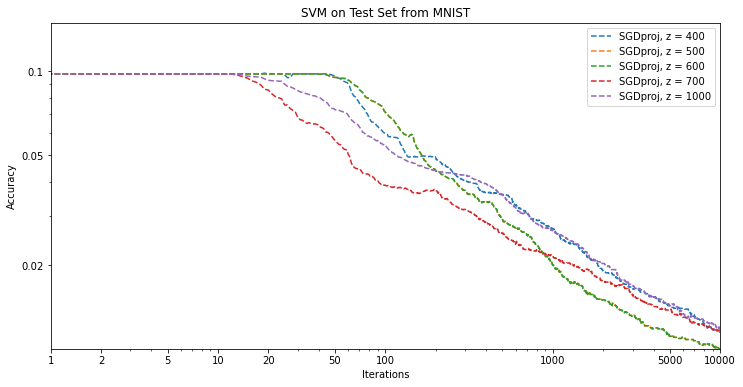

In [327]:
Z = [400, 500, 600, 700, 1000]
fig, ax = plt.subplots(figsize=(12,6))
for z in Z:
    xSGDproj1 = SGDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/40, z=z, iters=10000)
    rateSGDproj1 = rate(xSGDproj1, a_test, b_test)
    ax.plot(np.arange(10001), 1-rateSGDproj1,'--', label=f"SGDproj, z = {z}")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 10000)  
    ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
    ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
    ax.set_ylim(0.01, 0.15)  
    ax.set_yticks([0.02,0.05,0.1])
    ax.set_yticklabels(['0.02','0.05','0.1']) 
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Accuracy")
    ax.set_title("SVM on Test Set from MNIST")
    ax.legend(loc="upper right");

##### EXTRA : We compare SGD and SGDproj

In [66]:
%%time
#optimized parameter : lambda = 1/40
xSGD = SGD(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/40, iters=10000)
rateSGD = rate(xSGD, a_test, b_test)

CPU times: user 4.57 s, sys: 375 ms, total: 4.94 s
Wall time: 2.04 s


In [338]:
%%time
#optimized parameters : lambda = 1/40 & z = 600
xSGDproj = SGDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/40, z=300, iters=10000)
#lambda = 1/40 & z = 600 gets even better results
#xSGDproj = SGDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/40, z=600, iters=10000)
rateSGDproj = rate(xSGDproj, a_test, b_test)

CPU times: user 5.52 s, sys: 496 ms, total: 6.01 s
Wall time: 2.8 s


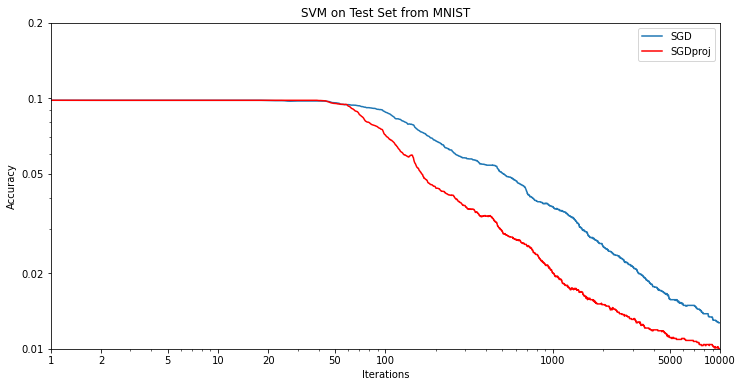

In [326]:
#parameters lambda=1/40, z=600
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateSGD, label="SGD")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.01, 0.2)  
ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right");

**2.** Compare the accuracy and the running time of the stochastic versus non-stochastic (projected) GD.

In [70]:
%%time
xGDproj2    = GDproj(a_train, b_train, np.zeros(a_train.shape[1]), gradreg, llambda=1/40, z=300., iters=10000)
rateGDproj2 = rate(xGDproj2, a_test, b_test)

CPU times: user 2h 34min 21s, sys: 25min 43s, total: 3h 5s
Wall time: 1h 52min 54s


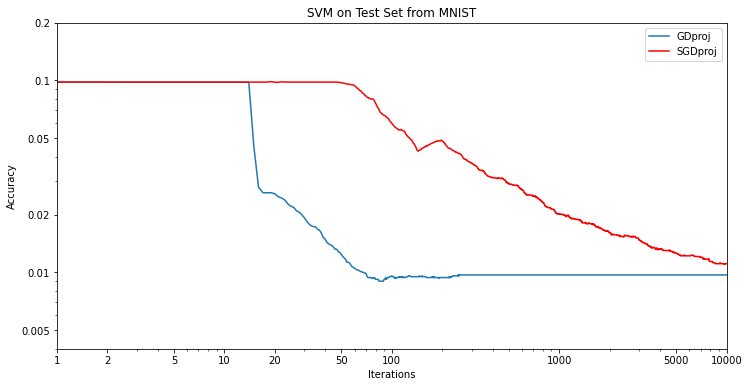

In [237]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateGDproj2, label="GDproj")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.004, 0.2)  
ax.set_yticks([0.005,0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.005','0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("GDproj_SGDproj.jpg");

We set the parameters for SGDproj and GDproj :    

Epoch $T = 10000$, $\eta_t = \frac{1}{\lambda t}$, $\lambda = 1/40$, $z = 300$.  

We recall that **n = 60000** is the size of the training set and **d = 784** is the dimension of the problem, i.e. the number of features per digit. 
      
The **Projected Stochastic Gradient Descent (SGDproj)** algorithm is dramatically faster than the **Projected Gradient Descent (GDproj)**. SGDproj operates 10000 iterations in 5 seconds when GDproj needs 3 hours 5 seconds.  

Indeed as studied during the lectures, each iteration of the GDproj costs $\mathcal{O}(nd + P)$ as it needs to compute $n$ gradients of dimension $d$ plus the projection on the $l^1$-ball of complexity $P$. Each iteration of the SGDproj computes a single gradient of dimension $d$ plus the projection, then the cost is $\mathcal{O}(d + P)$. From what is specified in the lecture's notes, we can expect a relative speed $\frac{\text SGDproj}{\text GDproj}$ of $\frac{1}{1000}$. Here we observe $\frac{1}{2000}$.  
  
After 100 iterations, the accuracy of the GDproj remains constant around 0.01. The SGDproj almost reaches the 0.01 accuracy at 10000 iterations. 

## 4 - Regularized Follow The Leader

**1.** Implement the Stochastic Mirror Descent and compare with the projected SGD.

We recall the Stochastic Mirror Descent (SMD) algorithm for linear SVM :

<hr>

**Algorithm 10 :** SMD for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$. <br/>
  **Initialization :** Initial point $x_1 = y_1 = 0$. <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Iteration :** Update
  
> $$\begin{align}
  \eta_{t+1} &= \sqrt{1/t} \\
  y_{t+1}    &= y_t - \eta_{t+1} \nabla \ell_{a_{I_t},b_{I_t}}(x_t) \\
  x_{t+1}    &= \Pi_{\mathcal{B}_1(z)}(y_{t+1})
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

**BEWARE MY LORD** : We use a **constant step size** : **$\eta = \sqrt{(z/T)}.$**

In [116]:
def SMDproj(a, b, instgrad, llambda, z=1., iters=100, eta=None, seed=0) :
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    y = np.zeros((iters+1, d))
    x = np.zeros((iters+1, d))
    if eta==None:
        eta = np.sqrt(z/iters)
    
    for t in range(iters) :
        y[t+1] = y[t] - eta*instgrad(x[t], a[t,], b[t], llambda)
        x[t+1] = proj_l1(y[t+1], z)
    
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

In [339]:
%%time
xSMDproj = SMDproj(a_train, b_train, gradreg, llambda=0, z=300, iters=10000)
rateSMDproj = rate(xSMDproj, a_test, b_test)

CPU times: user 5.09 s, sys: 377 ms, total: 5.47 s
Wall time: 2.66 s


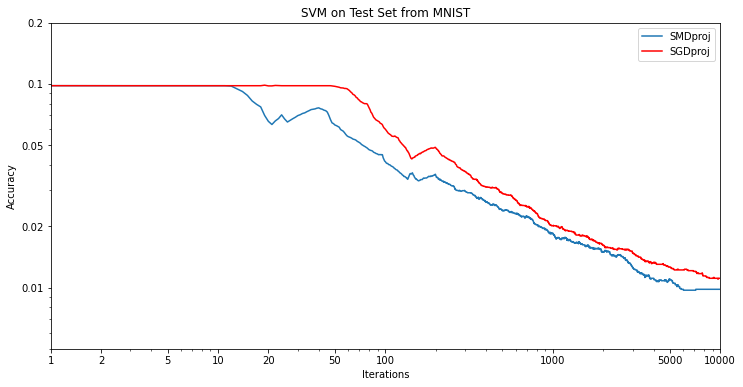

In [340]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateSMDproj, label="SMDproj")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.005, 0.2)  
ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("SMDproj_SGDproj.jpg");

Parameters for SMDproj :  
Epoch $T = 10000$, $\eta = \sqrt{z/T}$, $\lambda = 0$, $z = 300$. 
  
Parameters for SGDproj :  
Epoch $T = 10000$, $\eta_t = 1/\lambda t$, $\lambda = 1/40$, $z = 300$.  

We observe similar accuracies despite the slower theoretical rate of convergence of the $\textbf{SMDproj}$. Indeed, from the OCO lectures we know that the averaging regret bound of a $\textbf{SGD}$ algorithm for a $\lambda$-strongly convex problem and step size $\eta = 1/\lambda t$ is bounded by a term in the order of $\log{T}$. Whereas the regret bound of a $\textbf{SMD}$ is supposed to be bounded by a term in the order of $\sqrt{T}$ for an optimal constant step size $\eta$.

**2.** Implement the Stochastic Exponentiated Gradient $+/-$ and compare with the projected SGD.

We recall the Stochastic Exponentiated Gradient $+/-$ (SEG $+/-$) algorithm for linear SVM :

<hr>

**Algorithm 10 :** SEG $+/-$ for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$. <br/>
  **Initialization :** Initial point $x_1 = 0$, weights $w=1/(2d)\mathbb{1}$ and $\theta_1 = 0 \in \mathbb{R}^{2d}$. <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Iteration :** Update
  
> $$\begin{align}
  \eta_t         &= \sqrt{1/t} \\
  \theta_{t+1,i} &= \theta_{t,i} - \eta_t \nabla \ell_{a_{I_t},b_{I_t}}(x_t)_i \, \qquad 1 \le i \le d \\
  \theta_{t+1,i} &= \theta_{t,i} + \eta_t \nabla \ell_{a_{I_t},b_{I_t}}(x_t)_i \, \qquad d+1 \le i \le 2d \\
  w_{t+1}        &= \frac{\exp(\theta_{t+1})}{\sum_{i=1}^{2d} \exp(\theta_{t+1,i})} \\
  x_{t+1,i}      &= z(w_{t+1,i}-w_{t+1,i+d}) \, \qquad 1 \le i \le d
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

**BEWARE MY LORD** : We use a constant step **$\eta = \sqrt{2/T}$**.

In [406]:
def SEGpm(a, b, instgrad, llambda, z=1., iters=100, eta=None, seed=0) : 
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    w = (1/(2*d)) * np.ones(2*d)
    theta = np.zeros(2*d)
    x = np.zeros((iters+1, d))
    if eta==None:
        eta = eta = np.sqrt(2/iters) #change of learning rate
    
    for t in range(iters) :
        #if eta==None:
            #eta = np.sqrt(1/(t+1))
        instg = instgrad(x[t], a[t,], b[t], llambda)
        theta -= eta*np.hstack((instg, -instg))
        w = np.exp(theta) / sum(np.exp(theta))
        x[t+1] = z * (w[0:d]-w[d:2*d])
    
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

In [407]:
%%time
#If we set different parameters lambda=1/130, z=800 for SEGpm, it outperforms SMDproj
xSEGpm = SEGpm(a_train, b_train, gradreg, llambda=1/40, z=300, iters=10000)
rateSEGpm = rate(xSEGpm, a_test, b_test)

CPU times: user 6.39 s, sys: 570 ms, total: 6.96 s
Wall time: 3.57 s


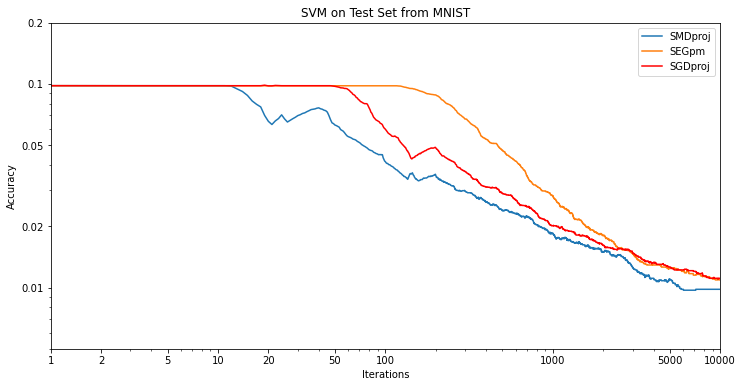

In [408]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateSMDproj, label="SMDproj")
ax.plot(np.arange(10001), 1-rateSEGpm, label="SEGpm")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.005, 0.2)  
ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("SEGpm_SGDproj.jpg");

After 3000 iterations accuracies are quite similar. 
We remark that if we change the parameters $\lambda$ and $z$ for $\textbf{SEGpm}$ to $\lambda=1/130$, $z=800$ it then outperforms both $\textbf{SMDproj}$ and $\textbf{SGDproj}$.

**3.** Implement the Stochastic AdaGrad and compare with the projected SGD.

First, we need to define the projection on the $\ell^1$-ball with weighted norm $\|\cdot\|_{D}$, where $D$ is a diagonal matrix and $\|x\|^2_D := x^T Dx$.

<hr>

**Algorithm 17 :** Projection on the ball $\mathcal{B}_1(z)$ with weighted norm $\|\cdot\|_D$

<hr>

> **Input :** $x \in \mathbb{R}^d$, $D$ diagonal and radius $z>0$ <br/>
  **If** $x \in \mathcal{B}_1(z)$ :
  
>>  **Return :** x

> **Else :**
  
>>  **Sort** $(Dx)_{(1)} \ge \dots \ge (Dx)_{(d)}$ <br/>
    **Find** $d_0 = \max\left\{ 1 \le i \le n : (Dx)_{(i)} - \frac{1}{\sum_{j=1}^{i} D_{(j)}^{-1}} \left( \sum_{j=1}^{i} x_{(j)} - z \right) > 0 \right\}$ <br/>
    **Define** $\theta^* = \frac{1}{\sum_{j=1}^{d_0} D_{(j)}^{-1}} \left( \sum_{j=1}^{d_0} x_{(j)} - z \right)$ <br/>
    **Return :** $w^* = \max(0, x-D^{-1} \theta^*) $

<hr>

In [144]:
def pib1w(x, w, z=1.) :
    # w is vecteur which represent a diagonal matrix
    if np.absolute(x).sum()>z and z!=np.inf :
        v = np.absolute(x*w)
        u = np.argsort(-v)
        sx = np.cumsum(np.absolute(x)[u])
        sw = np.cumsum(1/w[u])
        rho = 0
        if np.any(v[u] > (sx-z)/sw) :
            rho = np.max(np.where(v[u] > (sx-z)/sw))
        theta = (sx[rho]-z)/sw[rho]
        x = np.sign(x) * np.maximum(np.absolute(x)-theta/w, 0)
    return x

We now recall the Stochastic Adagrad algorithm for linear SVM :

<hr>

**Algorithm 16 :** Adagrad for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$. <br/>
  **Initialization :** Initial point $x_1 = y_1 = 0$ and $S_0 = 0$ (or $S_0 = \delta \mathbb{1}$ small) $\in \mathbb{R}^d$. <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Iteration :** Update
  
> $$\begin{align}
  S_t     &= S_{t-1} + \nabla \ell_{a_{I_t},b_{I_t}}(x_t)^2 \\
  D_t     &= Diag(\sqrt{S_t}) \\
  y_{t+1} &= x_{t} - D_t^{-1} \nabla \ell_{a_{I_t},b_{I_t}}(x_t) \\
  x_{t+1} &= \text{arg}\min_{x\in\mathbb{B}_1(z)} \|x - y_{t+1}\|_{D_t}^2
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

In [145]:
def Adaproj(a, b, instgrad, llambda, z=np.inf, iters=100, seed=0) :
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    x = np.zeros((iters+1, d))
    S = 0.0001 * np.ones(d)
    
    for t in range(iters) :
        instg = instgrad(x[t], a[t,], b[t], llambda)
        S += instg**2
        y = x[t] - (1/np.sqrt(S))*instg
        x[t+1] = pib1w(y, np.sqrt(S), z)
        
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

In [404]:
%%time
#Adaproj doesn't get good performances with lambda=1/40 and z=300
xAdaproj = Adaproj(a_train, b_train, gradreg, llambda=1/150, z=110, iters=10000)
rateAdaproj = rate(xAdaproj, a_test, b_test)

CPU times: user 4.86 s, sys: 382 ms, total: 5.24 s
Wall time: 2.25 s


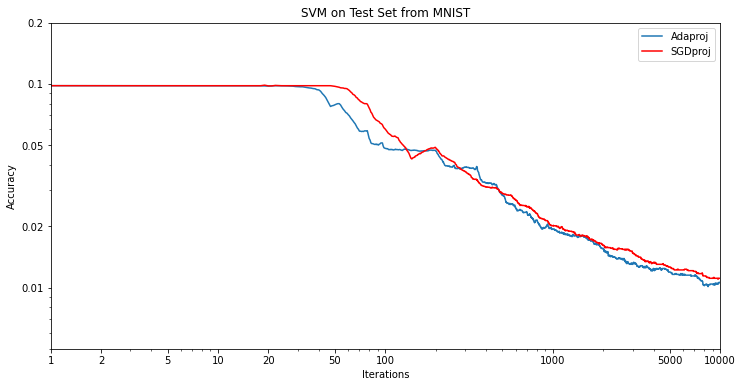

In [405]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateAdaproj, label="Adaproj")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.005, 0.2)  
ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("Adaproj_SGDproj.jpg");

At first $\textbf{SGDproj}$ gets better performances, but after 500 iterations, $\textbf{Adaproj}$ obtains a better accuracy.
We need to set different parameters for $\textbf{Adaproj}$, in particular the radius $z$. $\textbf{Adaproj}$ is an adaptive algorithm, here it probably takes advantage because it learns the strong sparsity of the pixel whereas the LASSO constraint (with the parameter $z$) in $\textbf{SGDproj}$ is fixed a priori.

## 5 - Online Newton Step

**1.** Implement the Stochastic Online Newton Step

We recall the Stochastic Online Newton Step algorithm for linear SVM :

<hr>

**Algorithm 16 :** ONS for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$, regularization parameter $\lambda >0$ and $\gamma >0$ <br/>
  **Initialization :** Initial point $x_1 = y_1 = 0$, $A_0 = (1/\gamma^2)I_d$ and $A_0^{-1} = \gamma^2 I_d$. <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Iteration :** Update
  
> $$\begin{align}
  \nabla_t &= \nabla \ell_{a_{I_t},b_{I_t}}(x_t) + \lambda x_t \\
  A_t &= A_{t-1} + \nabla_t \nabla_t^T \\
  A_t^{-1} &= A_{t-1}^{-1} - \frac{A_{t-1}^{-1} \nabla_t \nabla_t^T A_{t-1}^{-1}}{1 + \nabla_t^T A_{t-1}^{-1} \nabla_t} \\
  y_{t+1} &= x_t - \frac{1}{\gamma} A_t^{-1} \nabla_t \\
  x_{t+1} &= \text{arg}\min_{x\in\mathbb{B}_1(z)} \|x - y_{t+1}\|_{A_t}^2
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

In [181]:
def pib1w(x, w, z=1.) :
    # w is vecteur which represent a diagonal matrix
    if np.absolute(x).sum()>z and z!=np.inf :
        v = np.absolute(x*w)
        u = np.argsort(-v)
        sx = np.cumsum(np.absolute(x)[u])
        sw = np.cumsum(1/w[u])
        rho = 0
        if np.any(v[u] > (sx-z)/sw) :
            rho = np.max(np.where(v[u] > (sx-z)/sw))
        theta = (sx[rho]-z)/sw[rho]
        x = np.sign(x) * np.maximum(np.absolute(x)-theta/w, 0)
    return x

def ONS(a, b, instgrad, llambda, gamma, z=1., iters=100, seed=0) :
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    y = np.zeros((iters+1, d))
    x = np.zeros((iters+1, d))
    A = (1/gamma**2)*np.eye(d)
    A_inv = (gamma**2)*np.eye(d)
    
    for t in range(iters) :
        instg = instgrad(x[t], a[t,], b[t], llambda)
        A += (instg.reshape(-1,1)).dot(instg.reshape(1,-1))
        Ainstg = A_inv.dot(instg)
        A_inv -= (1+instg.dot(A_inv.dot(instg)))**(-1) * Ainstg.dot(np.transpose(Ainstg))
        y[t+1] = x[t] - (1/gamma)*A_inv.dot(instg)
        x[t+1] = pib1w(y[t+1], np.diag(A), z)
    
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

**2.** Compare its performances in term of accuracy and running time with the other methods

In [232]:
%%time
xONS = ONS(a_train, b_train, gradreg, llambda=1/50, gamma=1/6900 , z=200, iters=10000)
rateONS = rate(xONS, a_test, b_test)

CPU times: user 55.8 s, sys: 617 ms, total: 56.4 s
Wall time: 14.6 s


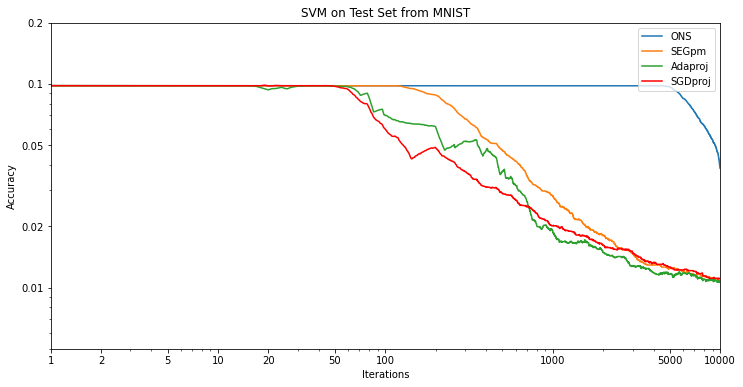

In [245]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(10001), 1-rateONS, label="ONS")
ax.plot(np.arange(10001), 1-rateSEGpm, label="SEGpm")
ax.plot(np.arange(10001), 1-rateAdaproj, label="Adaproj")
ax.plot(np.arange(10001), 1-rateSGDproj, color='red', label="SGDproj")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
ax.set_ylim(0.005, 0.2)  
ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("ONS.jpg");

## 6 - Exploration methods

**1.** Implement the Stochastic Randomized Exponentiated Gradient $+/-$ and the Stochastic Bandit Exponentiated Gradient $+/-$.

We recall the Stochastic Randomized Exponentiated Gradient $+/−$ (SREGpm) algorithm for linear SVM :

<hr>

**Algorithm 16 :** SREG $+/-$ for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$ <br/>
  **Initialization :** Initial point $x_1 = 0$, weights $w=1/(2d)\mathbb{1}$  <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Pick a direction randomly :** $J_t \in \{1,\dots,d\}$ uniformly <br/>
  **Iteration :** Update
  
> $$\begin{align}
  \eta_t      &= 1/\sqrt{dt} \\
  w_{t,J_t}   &= \exp(-\eta_t d \nabla \ell_{a_{I_t},b_{I_t}}(x_t)_{I_t})w_{t,J_t} \\ 
  w_{t,J_t+d} &= \exp(\eta_t d \nabla \ell_{a_{I_t},b_{I_t}}(x_t)_{I_t})w_{t,J_t+d} \\
  w_{t+1}     &= \frac{w_t}{\sum_{i=1}^{2d} w_{t,i}} \\
  x_{t+1,i}   &= z(w_{t+1,i}-w_{t+1,i+d}) \, \qquad 1 \le i \le d
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

In [460]:
def SREGpm(a, b, instgrad, llambda, z=1., iters=100, seed=0) :
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    x = np.zeros((iters+1, d))
    w = (1/(2*d)) * np.ones(2*d)
    
    for t in range(iters) :
        eta = 1/np.sqrt(d*(t+1))
        j = random.choices(np.arange(d), k=300)
        instgj = instgrad(x[t,j], a[t,j], b[t], llambda)
        w[j] = w[j] * np.exp(-eta*d*instgj)
        w[j+d] = w[j+d] * np.exp(eta*d*instgj)
        w = w/np.sum(w)
        x[t+1] = z*(w[:d]-w[d:])
        
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T


We recall the Stochastic Bandit Exponentiated Gradient $+/−$ (SBEGpm) algorithm for linear SVM :

<hr>

**Algorithm 16 :** SBEG $+/-$ for linear SVM

<hr>

> **Parameters :** Epoch $T$, radius $z>0$ <br/>
  **Initialization :** Initial point $x_1 = 0$, weights $w=1/(2d)\mathbb{1}$  <br/>
  Sample uniformly i.i.d. : $(I_t)_{1 \le t \le T}$ from $\{1,\dots,n\}$ <br/>
  For each iteration $t=1,\dots,T$ : <br/>
  **Sample an action :** $A_t \in \{\pm e_1,\dots,\pm e_d\} \sim w_t$ that determinate a coordinate $J_t$ and a sign $\pm_t \in \{+1,-1\}$ <br/>
  **Iteration :** Update
  
> $$\begin{align}
  \eta_t                            &= 1/\sqrt{dt} \\
  w_{t,J_t+d\mathbb{1}(\pm_t=-1)}   &= \exp(- \pm_t \eta_t d \nabla \ell_{a_{I_t},b_{I_t}}(x_t)_{I_t} / w_{t,J_t+d\mathbb{1}(\pm_t=-1)}) \\ 
  w_{t+1}                           &= \left(1-\eta_t\right) \frac{w_t}{\sum_{i=1}^{2d} w_{t,i}} + \frac{\eta_t}{2d} \\
  x_{t+1,i}                         &= z(w_{t+1,i}-w_{t+1,i+d}) \, \qquad 1 \le i \le d
  \end{align}$$

> **Return :** $\bar{x}_{T+1} = \frac{1}{T+1} \sum_{t=1}^{T+1} x_t$

<hr>

In [463]:
def SBEGpm(a, b, instgrad, llambda, z=1., iters=100, seed=0) : 
    random.seed(seed)
    ind = random.choices(np.arange(b.size), k=iters)
    a = a[ind,]
    b = b[ind]
    d = a.shape[1]
    x = np.zeros((iters+1, d))
    w = (1/(2*d)) * np.ones(2*d)
    
    for t in range(iters) : 
        eta = 1/np.sqrt(d*(t+1))
        A = np.random.choice(2*d, size=1, p=w)[0]
        j = A*(A<d)+(A-d)*(A>=d)
        s = 1-2*(A>=d)
        instgj = instgrad(x[t,j], a[t,j], b[t], llambda)
        w[A] = np.exp(-s*eta*instgj/w[A]) * w[A]
        w = (1-eta) * w/w.sum() + eta/(2*d)
        x[t+1] = z*(w[:d]-w[d:])
        
    return (np.cumsum(x, axis=0).T / np.arange(1,x.shape[0]+1)).T

**2.** Discuss their convergence. Is it in accordance with the regret bounds established during OCO lectures ?

In [465]:
%%time
xSREGpm = SREGpm(a_train, b_train, instgradreg, llambda=1/40, z=300., iters=10000)

TypeError: can only concatenate list (not "int") to list

In [448]:
rateSREGpm = rate(xSREGpm1, a_test, b_test)

In [421]:
%%time
xSBEGpm = SBEGpm(a_train, b_train, instgradreg, llambda=1/40, z=300., iters=10000)
rateSBEGpm = rate(xSBEGpm, a_test, b_test)

CPU times: user 5.63 s, sys: 544 ms, total: 6.17 s
Wall time: 3.01 s


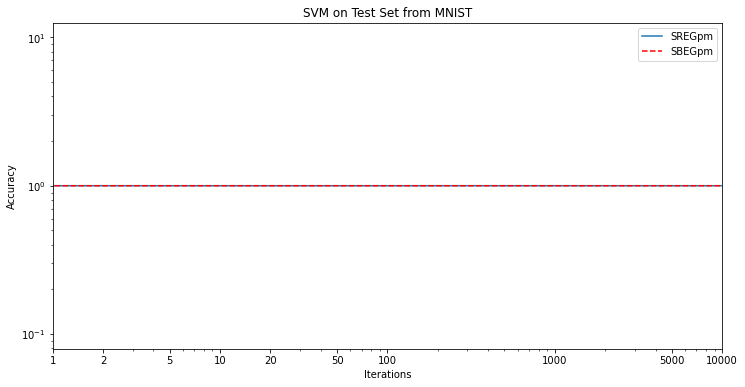

In [431]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(np.arange(10001), 1-rateSREGpm, label="SREGpm")
ax.plot(np.arange(10001), 1-rateSBEGpm,'--r', label="SBEGpm")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 10000)  
ax.set_xticks([1,2,5,10,20,50,100,1000,5000,10000])
ax.set_xticklabels(['1','2','5','10','20','50','100','1000','5000','10000']) 
#ax.set_ylim(0.005, 0.2)  
#ax.set_yticks([0.01,0.02,0.05,0.1,0.2])
#ax.set_yticklabels(['0.01','0.02','0.05','0.1','0.2']) 
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_title("SVM on Test Set from MNIST")
ax.legend(loc="upper right")
plt.savefig("SREGpm_SBEGpm.jpg");

## 7 - Other methods from the chosen article

In [424]:
def hinge_reg(x, a, b, lamb):
    hinge = 1 - b * np.dot(x, a.T)
    hinge[hinge <= 0] = 0
    return hinge.mean() + lamb/2 * (x^2).sum()
def grad_hinge_reg(x, a, b, lamb):
    threshold = b * np.dot(x, a.T)
    grad      = - np.multiply(b, a.T).T
    grad[threshold >= 1] = 0
    return grad.reshape(-1,784).mean(0) + lamb * x

**1.** Implement the method from the chosen article.

In [425]:
def SGD_pas(a_train, b_train, init, T, lamb, alpha, C):
    #initialisation
    x = init
    n = a_train.shape[0]
    I = np.random.randint(0, n-1, T+1) # 0 to n-1 included (idx diff maths)
    G = grad_hinge_reg(x, a_train[I[0]], b_train[I[0]], lamb)
    X = [x]
    GRAD = [G]
    for t in np.arange(1, T+1):  
        ynew = x - C*G/(t**alpha) 
        x     = ynew # simple SGD without projection
        ind   = I[t]
        G     = grad_hinge_reg(x, a_train[ind], b_train[ind], lamb)
        X.append(x)
        GRAD.append(G)
    X = np.array(X)
    X_bar     = X.cumsum(0) * (1/np.arange(1,T+2)).reshape(T+1,1) # successive means
    GRAD = np.array(GRAD)
    return (X, X_bar, GRAD)

In [426]:
def calculateErr(listeX, a, b, lambd):
    res = []
    accuracy = []
    hinge = np.vectorize(lambda x : max(0,1-x))
    vectRes = np.array([b for i in range(listeX.shape[0])])*listeX.dot(a.T)
    res1 = np.mean(hinge(vectRes), axis = 1) + np.array([lambd*(np.linalg.norm(x)**2)/2 for x in listeX])
    res2 = np.array([np.mean(vectRes[i]>0) for i in range(vectRes.shape[0])])
    return([res1, res2])

In [427]:
lambd = 0.33
CRun = np.array([0.7,1,1.5,2,4,10])/lambd
N = 100
NRun = 20
listeFinale = []
listeSigma = []
val = 0
for C in CRun:
    listeRun = []
    for i in range(NRun):
        res = SGD_pas(a_train, b_train, np.array([0 for i in range(784)]), N, 0.33, 1, C)
        listeRun.append(calculateErr(res[0], a_train, b_train, 0.33)[0])
    listeRun = np.array(listeRun)
    listeFinale.append(listeRun.mean(0))
    listeSigma.append(listeRun.std(0))
    val = val+1
    print(val)

1
2
3
4
5
6


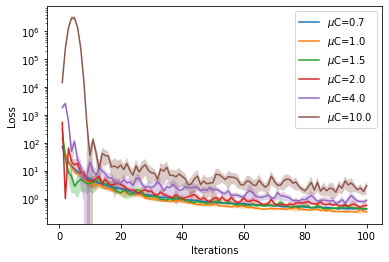

In [428]:
listeFinale = np.array(listeFinale)
listeSigma = np.array(listeSigma)
for i in range(listeFinale.shape[0]):
    Y1 = listeFinale[i] -1.96*listeSigma[i]/np.sqrt(NRun)
    Y2 = listeFinale[i] +1.96*listeSigma[i]/np.sqrt(NRun)
    plt.fill_between(np.arange(listeFinale.shape[1])[1:], Y1[1:], Y2[1:], alpha = 0.3)
    plt.plot(np.arange(listeFinale.shape[1])[1:], listeFinale[i][1:], label = "$\mu$C=" +  str(CRun[i]*lambd))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()